# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.480371,False,-3.135012
1,0.103664,False,0.715332
2,0.786123,True,6.242168
3,1.173100,True,7.587087
4,-1.842647,False,-4.290283
...,...,...,...
995,1.960450,True,9.968173
996,1.775299,True,8.235707
997,0.037464,False,-2.769256
998,1.196104,True,8.618906


<Axes: xlabel='v0'>

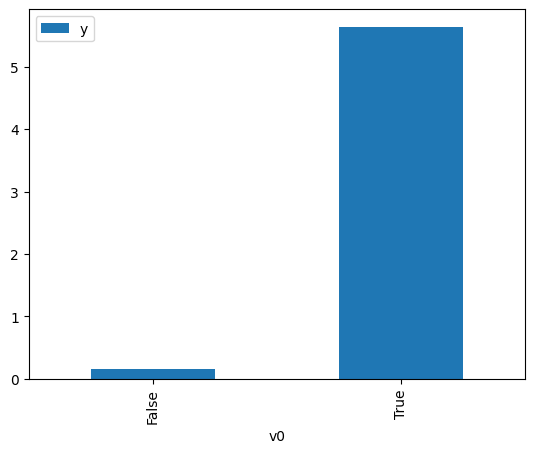

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

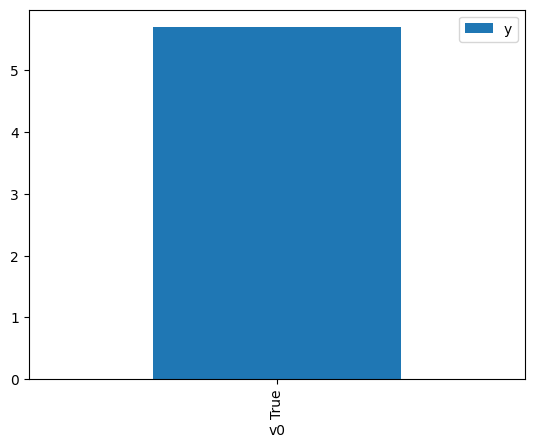

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.302360,False,3.866001,0.076712,13.035744
1,1.003934,False,3.209871,0.129154,7.742682
2,-0.327079,False,-0.662447,0.662808,1.508732
3,0.331417,False,1.722785,0.353726,2.827047
4,-0.727175,False,-1.064258,0.810407,1.233948
...,...,...,...,...,...
995,1.221924,False,3.217336,0.088531,11.295490
996,-1.620160,False,-3.897455,0.960322,1.041317
997,-0.316795,False,-0.289759,0.658331,1.518992
998,0.697003,False,1.832039,0.212065,4.715531


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.768444,True,8.952498,0.967480,1.033613
1,-0.144542,True,4.568834,0.420330,2.379083
2,-0.195102,True,5.575443,0.396616,2.521333
3,-0.563416,True,2.818751,0.243294,4.110251
4,-0.364618,True,5.110311,0.321101,3.114289
...,...,...,...,...,...
995,1.196104,True,8.618906,0.907339,1.102123
996,-0.712902,True,2.999350,0.193888,5.157630
997,-0.435223,True,6.260753,0.291976,3.424934
998,-0.196658,True,5.494470,0.395893,2.525935


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.963
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                          1.289e+04
Date:                Sat, 05 Aug 2023   Prob (F-statistic):                        0.00
Time:                        05:50:51   Log-Likelihood:                         -1470.2
No. Observations:                1000   AIC:                                      2944.
Df Residuals:                     998   BIC:                                      2954.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3322      0.038     60.900      0.000       2.257       2.407
x2             5.0073      0.053     93.925      0.000       4.903       5.112
==============================================================================
Omnibus:                        0.627   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.731   Jarque-Bera (JB):                0.681
Skew:                          -0.058   Prob(JB):                        0.711
Kurtosis:                       2.945   Cond. No.                         1.98
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""